# Парсинг вакансий с Хабр.Карьера по направлениям "Аналитика данных" и "Data Science".

**Цель:** написание алгоритма парсинга данных по вакансиям для IT-специалистов с сайта [career.habr.com/vacancies](https://career.habr.com/vacancies?type=all), анализ и визуализация результатов.

Алгоритм позволяет получить информацию о вакансиях по направлениям **Аналитика данных и Data Science** в разрезе уровней, компании и навыков.

За основу взят регион: **Москва.**

**Особенности работы** с сайтом career.habr.com/vacancies: так как в задании требуется получить информацию по направлениям "Аналитика данных" и "Data Science", то для отбора будем использовать фильтр "специализация", отдельно поле "Поиск" нам не потребуется в данном случае.

Последовательно выберем из раздела "Аналитика" - "Аналитик по данным", чему в парсере будет соответствовать filter_number = 3, затем в разделе "Искусственный интеллект" - "Ученый по данным/(Data Scientist)", чему в парсере будет соответствовать filter_number = 4.

Региону "Москва" соответствует параметр 4, перед параметром специализации, его мы менять не будем, так как берем его за основу в двух направлениях по вакансиям.

### Парсинг данных.

In [1]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
# filter_number фильтрует вакансии по специализации. 
# Параметр 3 - для аналитики, 4 - для DS.

def vacancy_info(filter_number):
    data = []
    for page in range(1,5):
        url = f'https://career.habr.com/vacancies?locations[]=c_678&page={page}&s[]=4{filter_number}&type=all'
        requests.get(url)
        pages = requests.get(url)
        soup = BeautifulSoup(pages.text,'lxml')

        vacancies = soup.find_all('div', class_='vacancy-card__inner')
        

        for vacancy in vacancies:
            skills = vacancy.find('div', class_='vacancy-card__skills').text.split(' • ')[1:]
            company = vacancy.find('div', class_='vacancy-card__company-title').text
            grade = vacancy.find('div', class_='vacancy-card__skills').text.split(' • ')[0]
            name_of_vacancy = vacancy.find('a', class_='vacancy-card__title-link').text
            salary = vacancy.find('div', class_='basic-salary').text
            date_of_publication = vacancy.find('time', class_='basic-date')['datetime']
            
            data.append([skills,company,name_of_vacancy,salary,date_of_publication,grade])

        columns = ['skills','company','vacancy','salary','date_of_publication','grade']
        table = pd.DataFrame(data, columns = columns)

        table[['position', 'level']] = table['grade'].str.split(',', n=1, expand=True)
        table = table.drop('grade', axis=1)
        table['date_of_publication'] = pd.to_datetime(table['date_of_publication']).dt.date
        table['count_skills'] = table['skills'].apply(len)

    
    return table

### Анализ вакансий по направлению "Аналитик данных"

Для начала найдем отдельно информацию о вакансиях по направлению **Аналитик данных** .

In [3]:
analytics = vacancy_info(3)
analytics.head()

,skills,company,vacancy,salary,date_of_publication,position,level,count_skills
0,"[Matlab, C, C++]",БЮРО 1440,Программист - исследователь беспроводных систе...,,2023-10-31,Аналитик по данным,Старший (Senior),3
1,"[SQL, Python, Git, Apache Spark, Apache Hadoop...",beeline,Senior Data Scientist,,2023-10-31,Аналитик по данным,Старший (Senior),9
2,"[SQL, Python, Алгоритмы и структуры данных, Gi...",Холдинг Т1,Data аналитик (Виртуальные ассистенты),,2023-10-31,Аналитик по данным,Средний (Middle),5
3,"[Python, Pandas]",Первая Грузовая Компания,Data Analyst,,2023-10-30,Аналитик по данным,Средний (Middle),2
4,"[CSS, PowerBI, Powershell, SSIS, Oracle PL/SQL]",ДИКСИ,Программист-аналитик SQL,,2023-10-29,Аналитик по данным,None,5


**Навыки**

In [4]:
top_set_skills_a = analytics.skills.value_counts().head()
top_set_skills_a

[SQL, Python]                                                                                                     2
[Matlab, C, C++]                                                                                                  1
[SQL, Python, Git, Apache Spark, Apache Hadoop, Apache Airflow, Математическая статистика, Docker, Kubernetes]    1
[Qlik Sense, Анализ данных, Microsoft Excel, Математическая статистика, Визуализация, DWH]                        1
[Powershell, Visual Basic, Python, SQL]                                                                           1
Name: skills, dtype: int64

In [5]:
print(f'Мы видим, что наиболее частые наборы навыков {top_set_skills_a.index[0]} и {top_set_skills_a.index[1]}.')

Мы видим, что наиболее частые наборы навыков ['SQL', 'Python'] и ['Matlab', 'C', 'C++'].


Теперь исследуем, какой из всех навыков самые восстребованный.

In [6]:
top_skills_a = pd.Series(analytics.skills.sum()).value_counts().head()
top_skills_a

SQL              13
Python           13
Apache Hadoop     4
Базы данных       3
Анализ данных     3
dtype: int64

In [7]:
print(f'Навык, который требуется чаще всего в вакансиях на аналитика данных, - {top_skills_a.index[0]}. На 2-м месте - {top_skills_a.index[1]}, на 3-м - {top_skills_a.index[2]}')

Навык, который требуется чаще всего в вакансиях на аналитика данных, - SQL. На 2-м месте - Python, на 3-м - Apache Hadoop


**Уровень**

Сгруппируем вакансии по уровню.

In [8]:
grade_a = analytics.groupby('level')['level'].count().sort_values(ascending = True)
grade_a

level
 Стажёр (Intern)     1
 Старший (Senior)    7
 Средний (Middle)    9
Name: level, dtype: int64

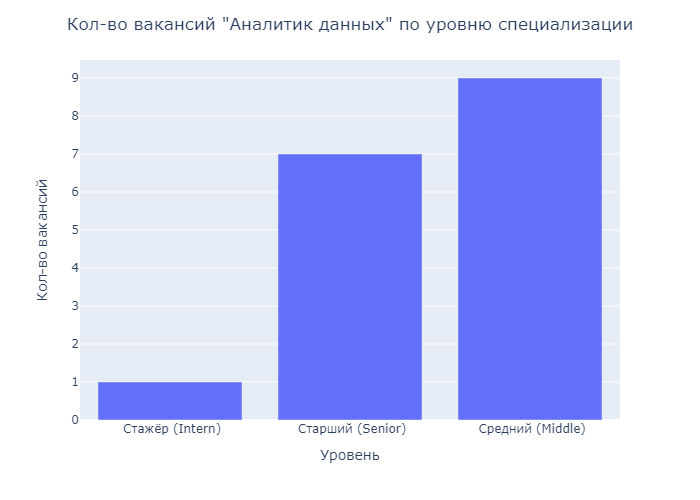

In [9]:
fig1 = px.bar(grade_a, x=grade_a.index, y=grade_a, labels=dict(index = 'Уровень', y='Кол-во вакансий'))
fig1.update_layout(title_text='Кол-во вакансий "Аналитик данных" по уровню специализации', title_x=0.5)
fig1.show("png")

In [10]:
print(f'Наибольшим спросом пользуется позиция:{grade_a.index[-1]}. На данный момент активно {grade_a.values[-1]} позиций. Меньше всего позиций на уровень: {grade_a.index[0]}')

Наибольшим спросом пользуется позиция: Средний (Middle). На данный момент активно 9 позиций. Меньше всего позиций на уровень:  Стажёр (Intern)


**Компания**

In [11]:
companies_a = analytics.groupby('company')['company'].count().sort_values(ascending = False)
companies_a.head()

company
beeline            3
Почта Банк         2
Холдинг Т1         2
Action tech        1
Bell Integrator    1
Name: company, dtype: int64

In [12]:
print(f' Больше всего вакансий у компании "{companies_a.index[0]}". На втором месте по кол-ву открытых компаний по анализу данных "{companies_a.index[1]}".')

 Больше всего вакансий у компании "beeline". На втором месте по кол-ву открытых компаний по анализу данных "Почта Банк".


### Анализ вакансий по направлению "Data Science"

In [13]:
data_science = vacancy_info(4)
data_science.head()

,skills,company,vacancy,salary,date_of_publication,position,level,count_skills
0,"[Машинное обучение, Python, SQL, Pandas, PyTorch]",Bell Integrator,Data Scientist (Middle/Senior) Remote,,2023-10-30,Ученый по данным,Средний (Middle),5
1,"[Python, Java, Apache Spark, Apache Hadoop]",VK,"Инженер-разработчик Data Science (проект ""Лент...",,2023-10-29,Ученый по данным,Средний (Middle),4
2,"[SQL, Python]",Банк ВТБ,Data Scientist (сопровождение процесса разрабо...,,2023-10-28,Ученый по данным,Средний (Middle),2
3,"[Python, SQL, Oracle]",SM Lab,Data Scientist (Прогнозирование),,2023-10-26,Ученый по данным,Средний (Middle),3
4,"[SQL, SAS, Python, NumPy, Pandas]",Строительный Двор,Data Scientist,,2023-10-25,Ученый по данным,Средний (Middle),5


**Навыки**

In [14]:
top_skills_d = pd.Series(data_science.skills.sum()).value_counts().head()
top_skills_d

Python               8
SQL                  5
Машинное обучение    3
Pandas               2
PyTorch              2
dtype: int64

In [15]:
print(f'Для Data Science самый популярный навык уже другой - {top_skills_d.index[0]}, а на 2-м месте - {top_skills_d.index[1]}. Ровно наоборот по сравнению с аналитиками данных.')

Для Data Science самый популярный навык уже другой - Python, а на 2-м месте - SQL. Ровно наоборот по сравнению с аналитиками данных.


**Уровень**

In [16]:
grade_d = data_science.groupby('level')['level'].count().sort_values(ascending = True)
grade_d

level
 Старший (Senior)    3
 Средний (Middle)    6
Name: level, dtype: int64

In [17]:
print(f'Наибольшим спросом пользуется позиция:{grade_d.index[-1]}. На данный момент активно {grade_d.values[-1]} позиций. Меньше всего позиций на уровень: {grade_d.index[0]}')

Наибольшим спросом пользуется позиция: Средний (Middle). На данный момент активно 6 позиций. Меньше всего позиций на уровень:  Старший (Senior)


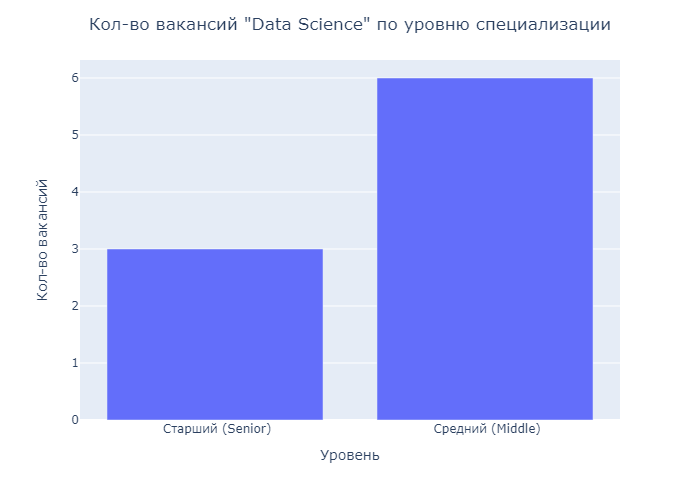

In [18]:
fig2 = px.bar(grade_d, x=grade_d.index, y=grade_d,labels=dict(index = 'Уровень', y='Кол-во вакансий'))
fig2.update_layout(title_text='Кол-во вакансий "Data Science" по уровню специализации', title_x=0.5)
fig2.show("png")

**Компания**

In [19]:
companies_d = data_science.groupby('company')['company'].count().sort_values(ascending = False)
companies_d.head()

company
BIA-Technologies    1
Bell Integrator     1
SM Lab              1
TINKOFF             1
VK                  1
Name: company, dtype: int64

### Анализ вакансий по обоим направлениям "Аналитик данных" и "Data Science"

В таблице мы видим разделение по уровням и по направлениям.

In [20]:
boths = pd.concat([analytics,data_science])
boths.head()

,skills,company,vacancy,salary,date_of_publication,position,level,count_skills
0,"[Matlab, C, C++]",БЮРО 1440,Программист - исследователь беспроводных систе...,,2023-10-31,Аналитик по данным,Старший (Senior),3
1,"[SQL, Python, Git, Apache Spark, Apache Hadoop...",beeline,Senior Data Scientist,,2023-10-31,Аналитик по данным,Старший (Senior),9
2,"[SQL, Python, Алгоритмы и структуры данных, Gi...",Холдинг Т1,Data аналитик (Виртуальные ассистенты),,2023-10-31,Аналитик по данным,Средний (Middle),5
3,"[Python, Pandas]",Первая Грузовая Компания,Data Analyst,,2023-10-30,Аналитик по данным,Средний (Middle),2
4,"[CSS, PowerBI, Powershell, SSIS, Oracle PL/SQL]",ДИКСИ,Программист-аналитик SQL,,2023-10-29,Аналитик по данным,None,5


**Компания**

Определим топ-5 компаний по кол-ву открытых вакансий по специализациям анализ данных и data science.

In [21]:
companies_both = boths.groupby('company')['company'].count().sort_values(ascending = False)
companies_both.head()

company
beeline            3
Яндекс             2
Bell Integrator    2
Холдинг Т1         2
VK                 2
Name: company, dtype: int64

In [22]:
print(f' Компании {companies_both.index[0]} и {companies_both.index[1]} являются лидерами по кол-ву открытых вакансий  по специализациям анализ даннх и data science на данный момент.')

 Компании beeline и Яндекс являются лидерами по кол-ву открытых вакансий  по специализациям анализ даннх и data science на данный момент.


**Уровень**

Посмотрим на кол-во вакансий в разрезе грейдов по специализациям.

In [23]:
sep_level = boths.groupby('position')['level'].value_counts()
sep_level

position            level            
Аналитик по данным   Средний (Middle)    9
                     Старший (Senior)    7
                     Стажёр (Intern)     1
Ученый по данным     Средний (Middle)    6
                     Старший (Senior)    3
Name: level, dtype: int64

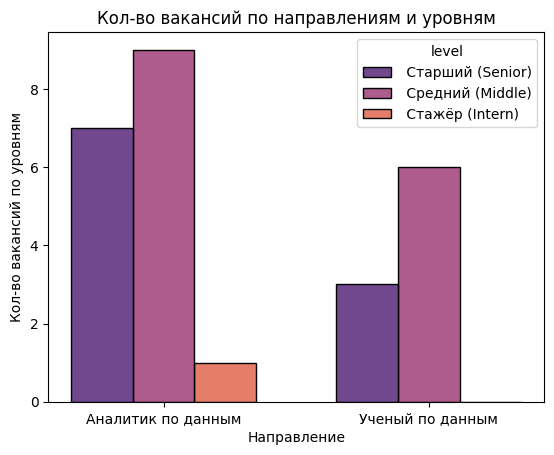

In [24]:
sns.histplot(data=boths, x="position", hue="level",  multiple="dodge",shrink=.7, palette = sns.color_palette("inferno",4)).set(title = 'Кол-во вакансий по направлениям и уровням')
plt.xlabel('Направление')
plt.ylabel('Кол-во вакансий по уровням')
plt.show()

In [25]:
print(f' Незавивимо от специализации больше всего вакансий уровня:{sep_level.index[0][1]}')

 Незавивимо от специализации больше всего вакансий уровня: Средний (Middle)


Далее рассмотрим разбиение на уровни без разделения по направлениям.

In [26]:
both = boths.groupby('level')['level'].count().sort_values(ascending = True)
both

level
 Стажёр (Intern)      1
 Старший (Senior)    10
 Средний (Middle)    15
Name: level, dtype: int64

In [27]:
print(f'Наибольшим спросом пользуется позиция:{both.index[-1]}. На данный момент активно всего {both.values[-1]} позиций/я. Меньше всего позиций на уровень: {both.index[0]}')

Наибольшим спросом пользуется позиция: Средний (Middle). На данный момент активно всего 15 позиций/я. Меньше всего позиций на уровень:  Стажёр (Intern)


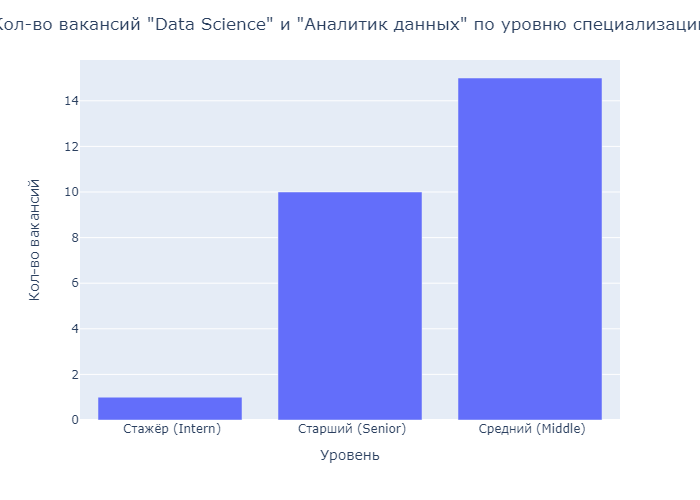

In [28]:
fig3 = px.bar(both, x=both.index, y=both, labels=dict(index = 'Уровень', y='Кол-во вакансий'))
fig3.update_layout(title_text='Кол-во вакансий "Data Science" и "Аналитик данных" по уровню специализации', title_x=0.5)
fig3.show("png")

Проведем интересную аггрегацию по уровню грейда и кол-ву требуемых навыков.

In [29]:
skills_table = boths.groupby('level')['count_skills'].mean().sort_values(ascending = False)
skills_table

level
 Старший (Senior)    4.1
 Стажёр (Intern)     4.0
 Средний (Middle)    3.6
Name: count_skills, dtype: float64

In [30]:
print(f'Мы видим, что больше всего требований к позиции {skills_table.index[0]} , меньше всего требований к позиции {skills_table.index[-1]} . Интересная корреляция. Получается, что для самых старших и самых низких грейдов меньше всего требований, а вот к средним больше всего.')

Мы видим, что больше всего требований к позиции  Старший (Senior) , меньше всего требований к позиции  Средний (Middle) . Интересная корреляция. Получается, что для самых старших и самых низких грейдов меньше всего требований, а вот к средним больше всего.


**Даты**

In [31]:
date_both = boths.groupby('date_of_publication')['date_of_publication'].count().sort_values(ascending = False)
date_both.head()

date_of_publication
2023-10-24    4
2023-10-26    4
2023-10-27    4
2023-10-31    3
2023-10-23    2
Name: date_of_publication, dtype: int64

In [32]:
print(f'Больше всего вакансий было выложено {date_both.index[0]} и {date_both.index[1]}. Следовательно, в следующем году можно ориентироваться на эти даты при поиске работы, чтобы быть первым при отклике.')

Больше всего вакансий было выложено 2023-10-24 и 2023-10-26. Следовательно, в следующем году можно ориентироваться на эти даты при поиске работы, чтобы быть первым при отклике.


## Статистический анализ.

Рассмотрим различия между средним кол-вом требуемых навыков для аналитиков и data scientists.

Сформулируем гипотезы:

**H0:** Статистически значимые различия между кол-вом нвыков для аналитиков и data scientists отсутствуют.

**H1:** Статистически значимые различия между кол-вом нвыков для аналитиков и data scientists существуют.

Для проверки гипотез используем т-критерий, так как именно он помогает сравнить две выборки между собой на предмет статистически значимых различий. Из существующих уровней значимости выберем 0,05, то есть существует 5% того, что результат обусловлен случайностью.

Перед проведением т-теста необходимо проверить данные на гомогенность дисперсий.

Проверим данные на гомогенность дисперсий с помощью **теста Левена**:

In [33]:
a = analytics.count_skills
ds = data_science.count_skills

st.levene(a, ds, center='mean')

LeveneResult(statistic=0.6089347115044794, pvalue=0.44223597104864365)

P - value имеет показатель > 0,05. Следовательно, мы не отвергаем гипотезу о равенстве дисперсий. Таким образом, параметр о гомогенности дисперсий соблден. -> Можем проводить т-тест.

In [34]:
alpha = .05

results = st.ttest_ind(
    a, 
    ds)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8530601134500868
Не получилось отвергнуть нулевую гипотезу


Т-критерий Стьюдента показал, что статистически значимых различий между кол-вом требуемых навыком для аналитиков и дата саентистов нет. Следовательно, для той и другой позиции необходимо примерно одинковое кол-во навыков.

In [35]:
display(HTML("<h2>Выводы:</h2>"))
print(f' * Таким образом, больше всего позиций среди "Data Science" и "Аналитик данных" по уровеню: {both.index[-1]}, наименьшим спросом на данный момент пользуется  - {both.index[0]}. ')
print()
print(f' * Всего позиций по направлению "Аналитик данных": {len(analytics)} .')
print()
print(f' * Всего позиций по направлению "Data Science": {len(data_science)} .')
print()
print(f' * Мы видим, что больше всего требований к позиции {skills_table.index[0]} , меньше всего требований к позиции {skills_table.index[-1]}? независимо от направления .')
print()
print(f' * Компании "{companies_both.index[0]}" и "{companies_both.index[1]}" являются лидерами по кол-ву открытых вакансий  по специализациям анализ даннх и data science на данный момент.')
print()
print(f' * Независимо от специализации больше всего вакансий уровня:{sep_level.index[0][1]}')

 * Таким образом, больше всего позиций среди "Data Science" и "Аналитик данных" по уровеню:  Средний (Middle), наименьшим спросом на данный момент пользуется  -  Стажёр (Intern). 

 * Всего позиций по направлению "Аналитик данных": 19 .

 * Всего позиций по направлению "Data Science": 9 .

 * Мы видим, что больше всего требований к позиции  Старший (Senior) , меньше всего требований к позиции  Средний (Middle)? независимо от направления .

 * Компании "beeline" и "Яндекс" являются лидерами по кол-ву открытых вакансий  по специализациям анализ даннх и data science на данный момент.

 * Независимо от специализации больше всего вакансий уровня: Средний (Middle)
